Exact k(x,y): 0.0619, RFF approx: 0.0175


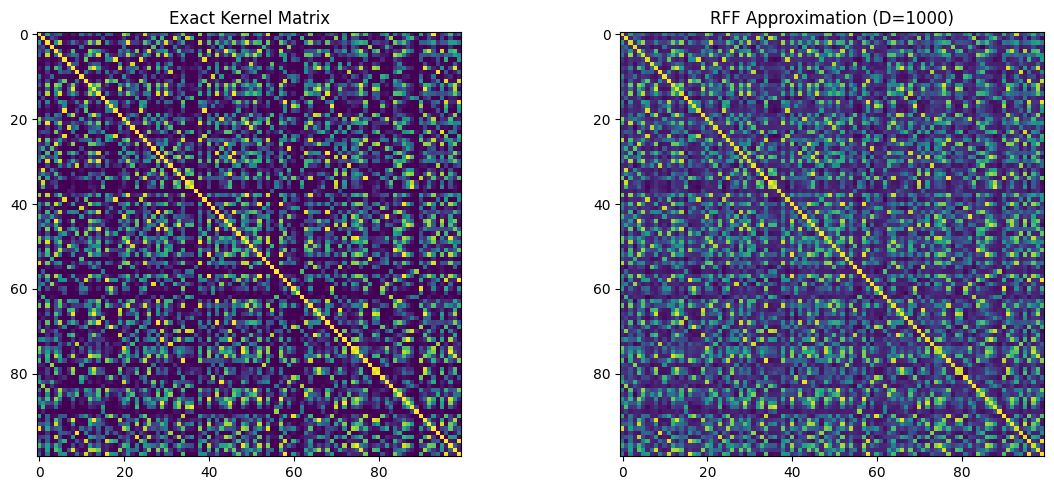

Exact Laplacian k(x,y): 0.1633, RBF approx: -69373.0260


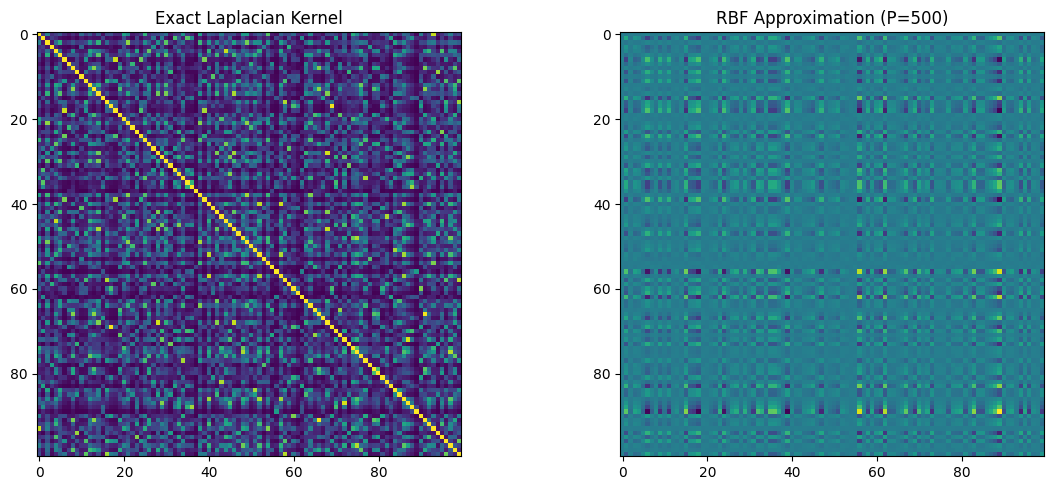

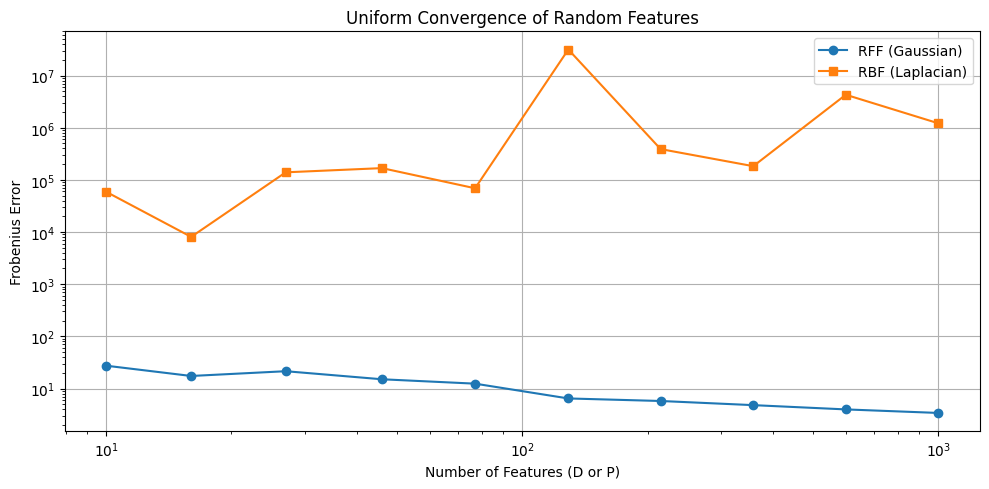

Training Results:
RFF+Ridge - Time: 0.06s, Accuracy: 0.4045
SVM       - Time: 0.03s, Accuracy: 1.0000


In [ ]:
# # Random Features for Large-Scale Kernel Machines

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from time import time

# ## 1. Random Fourier Features (RFF)
# Approximates shift-invariant kernels (e.g., Gaussian RBF) using Monte Carlo sampling from the kernel's Fourier transform.

def random_fourier_features(X, D, gamma=1.0):
    """Generate RFF features for kernel approximation that adapt to input dimension."""
    n, d = X.shape
    # Create distribution matching input dimension
    p_omega = multivariate_normal(mean=np.zeros(d), cov=2*gamma*np.eye(d))
    omega = p_omega.rvs(D)
    b = np.random.uniform(0, 2*np.pi, D)
    return np.sqrt(2/D) * np.cos(X @ omega.T + b)

# Example usage with 2D data for visualization
np.random.seed(42)
X_vis = np.random.randn(100, 2)  # 100 points in 2D for visualization
D = 1000
Z_rff = random_fourier_features(X_vis, D)

# Gaussian RBF kernel
kernel = lambda x, y: np.exp(-gamma * np.linalg.norm(x - y)**2)

# Compare exact vs. RFF kernel
x, y = X_vis[0], X_vis[1]
print(f"Exact k(x,y): {kernel(x, y):.4f}, RFF approx: {Z_rff[0] @ Z_rff[1]:.4f}")

# Plot kernel matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow([[kernel(x, y) for x in X_vis] for y in X_vis], cmap='viridis')
plt.title("Exact Kernel Matrix")

plt.subplot(1, 2, 2)
plt.imshow(Z_rff @ Z_rff.T, cmap='viridis')
plt.title(f"RFF Approximation (D={D})")
plt.tight_layout()
plt.savefig("assets/rff_comparison.png", bbox_inches='tight', dpi=300)
plt.show()

# ## 2. Random Binning Features (RBF)
# Approximates non-smooth kernels (e.g., Laplacian) using random grids.

def random_binning_features(X, P):
    """Generate RBF features for Laplacian kernel approximation."""
    n, d = X.shape
    Z = np.zeros((n, P))
    # Extended list of primes for higher dimensions
    primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]
    primes = np.array(primes[:d])  # Use first d primes
    
    for p in range(P):
        delta = np.random.exponential(scale=1.0, size=d)  # p(δ) = δ exp(-δ)
        u = np.random.uniform(0, delta)
        bins = np.floor((X - u[np.newaxis, :]) / delta[np.newaxis, :])
        Z[:, p] = np.sum(bins * primes[np.newaxis, :], axis=1)
    return Z / np.sqrt(P)

# Example usage with 2D data for visualization
P = 500
Z_rbf = random_binning_features(X_vis, P)
laplacian_kernel = lambda x, y: np.exp(-np.linalg.norm(x - y, ord=1))
print(f"Exact Laplacian k(x,y): {laplacian_kernel(x, y):.4f}, RBF approx: {Z_rbf[0] @ Z_rbf[1]:.4f}")

# Plot kernel matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow([[laplacian_kernel(x, y) for x in X_vis] for y in X_vis], cmap='viridis')
plt.title("Exact Laplacian Kernel")

plt.subplot(1, 2, 2)
plt.imshow(Z_rbf @ Z_rbf.T, cmap='viridis')
plt.title(f"RBF Approximation (P={P})")
plt.tight_layout()
plt.savefig("assets/rbf_comparison.png", bbox_inches='tight', dpi=300)
plt.show()

# ## 3. Theoretical Convergence
# Plot error vs. number of features to validate Claims 1-2 from the paper.

# Simulate convergence for RFF and RBF
Ds = np.logspace(1, 3, 10).astype(int)  # Reduced range for faster computation
errors_rff = []
for D in Ds:
    Z = random_fourier_features(X_vis, D)
    K_rff = Z @ Z.T
    K_exact = np.array([[kernel(x, y) for x in X_vis] for y in X_vis])
    errors_rff.append(np.linalg.norm(K_rff - K_exact, 'fro'))

Ps = np.logspace(1, 3, 10).astype(int)  # Reduced range for faster computation
errors_rbf = []
for P in Ps:
    Z = random_binning_features(X_vis, P)
    K_rbf = Z @ Z.T
    K_exact = np.array([[laplacian_kernel(x, y) for x in X_vis] for y in X_vis])
    errors_rbf.append(np.linalg.norm(K_rbf - K_exact, 'fro'))

plt.figure(figsize=(10, 5))
plt.loglog(Ds, errors_rff, 'o-', label='RFF (Gaussian)')
plt.loglog(Ps, errors_rbf, 's-', label='RBF (Laplacian)')
plt.xlabel("Number of Features (D or P)")
plt.ylabel("Frobenius Error")
plt.title("Uniform Convergence of Random Features")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("assets/convergence.png", bbox_inches='tight', dpi=300)
plt.show()

# ## 4. Empirical Comparison with SVM
# Compare training time and accuracy of RFF+Ridge vs. exact SVM.

# Generate synthetic data with 10 features
np.random.seed(42)
X_train = np.random.randn(1000, 10)
y_train = (X_train[:, 0] > 0).astype(int)

# RFF + Ridge
start = time()
Z_train = random_fourier_features(X_train, D=500)
model_rff = Ridge(alpha=1.0).fit(Z_train, y_train)
time_rff = time() - start
acc_rff = model_rff.score(Z_train, y_train)

# Exact SVM
start = time()
model_svm = SVC(kernel='rbf', gamma=gamma).fit(X_train, y_train)
time_svm = time() - start
acc_svm = model_svm.score(X_train, y_train)

print(f"Training Results:")
print(f"RFF+Ridge - Time: {time_rff:.2f}s, Accuracy: {acc_rff:.4f}")
print(f"SVM       - Time: {time_svm:.2f}s, Accuracy: {acc_svm:.4f}")